In [1]:
import tensorflow as tf
print(tf.__version__)

2.5.0


El siguiente paso es importar las bibliotecas numpy y matplotlib. Además, se define el método **plot_series** que se utilizará para hacer las gráficas de las series temporales.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

A continuación se descarga el dataset de las temperaturas mínimas diarias.

In [3]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /tmp/daily-min-temperatures.csv

--2021-06-09 16:34:07--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘/tmp/daily-min-temperatures.csv’

/tmp/daily-min-temp 100%[===================>]  66.33K  --.-KB/s    in 0.005s  

2021-06-09 16:34:07 (13.9 MB/s) - ‘/tmp/daily-min-temperatures.csv’ saved [67921/67921]



En este paso, se utilizará la biblioteca csv de Python para guardar y poder leer el dataset de temperaturas mínimas diarias que ha sido descargado en el paso anterior. Además, se construye la variable **series** que será donde se guarde la serie temporal. Por último, siempre que se trate con una serie temporal, es una buena práctica hacer un gráfico para poder verla y tener una idea de cómo es.

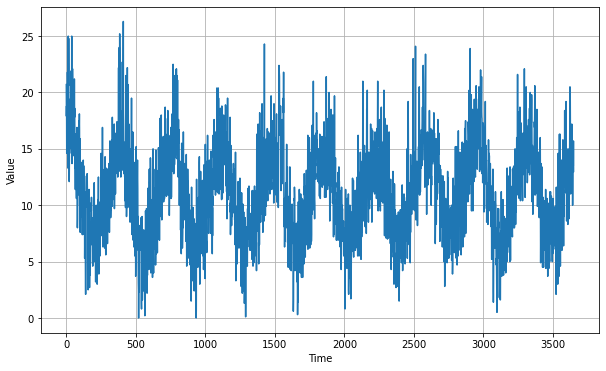

In [4]:
import csv
time_step = []
temps = []

with open('/tmp/daily-min-temperatures.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  step=0
  for row in reader:
    temps.append(float(row[1]))
    time_step.append(step)
    step = step + 1

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

# 2. Creación de las variables necesarias para el diseño de la red neuronal

Una técnica muy común cuando se trata con series temporales es utilizar una ventana temporal que se vaya desplazando sobre la serie temporal para reducir su análisis a lo que ocurre en ese ventana de forma local, para a continuación realizar el modelado global.

**Ejercicio 1 (0.4 puntos)**: Crear las variables de entrenamiento y validación y hacer la partición de las mismas. Las variables que hay que crear son:

*   time_train
*   x_train
*   time_valid
*   x_valid





In [5]:
## variables para la técnica de la ventana temporal
split_time = 2500
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


## Split del dataset en entrenamiento y validación

time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

2. Creación del método **windowed_datset** para poder utilizarlo en el modelo. Las entradas por parámetros del método son:

*   series
*   window_size
*   batch_size
*   shuffle_buffer

El resto de elementos que se usan para construir la función ventana temporal para explorar el dataset, son métodos de Python para tratar con series temporales.




In [6]:
# ventana temporal que se va moviendo por la serie temporal
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

# 3. Diseño de la función para predecir los siguientes valores de la serie temporal usando la técnica de la ventana temporal

A continuación, y usando como modelo el método **windowed_dataset** se procederá a adaptar el método **model_forecast** que se usará para predecir los siguientes valores de la serie temporal utilizando la técnica de la ventana temporal.

**Ejercicio 2 (1.6 puntos)**: completar el método model_forecast creando los elementos necesarios dentro del método:

1.   Crear la variable **ds** y darle el valor resultante del método **from_tensor_slices** pasando por parametro **series** **(0.4 puntos)**
2.   Actualizar la ventana (**window**) de la variable **ds** (nota: en este caso el tamaño es el mismo de la ventana, no es necesario que sea window_size+1) **(0.4 puntos)**
3.   Crear el **flat_map** de la variable, teniendo en cuenta que el tamaño es **window_size** **(0.4 puntos)**
4.   Añadir la siguiente linea de código: ds = ds.batch(32).prefetch(1)
5.   Crear la variable **forecast** en la que se usará el método **predict** **(0.4 puntos)**
6.   Por último, se devolverá la variable forecast.




In [7]:
def model_forecast(model, series, window_size):
## tu código para el método model_forecast del ejercicio 2 aquí
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size , shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size))
  ds = ds.batch(32).prefetch(1)
  forecast = model.predict(ds)

  return forecast

A continuación, se limpia la sesión de keras, y se inicializan las variables necesarias para poder diseñar el modelo de series temporales a entrenar usando RNN.

In [8]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256

# 4. Diseño de la red neuronal

**Ejercicio 3.1 (0.5 puntos)**: Hay que crear la variable **train_set** dándole el valor que se reciba del método **windowed_dataset**, los parametros que debe recibir este método son: **x_train, window_size, batch_size, shuffle_buffer_size**

In [9]:
## tu código aquí para el ejercicio 3
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

**Ejercicio 3.2 (4 puntos)**: Se debe construir la red neuronal de aprendizaje profunda basada para modelar la serie temporal de las temperaturas minimas diarias. Esta red neuronal debera contar con las siguientes capas ocultas:

1.   Una capa de convolución en una dimensión que tenga 32 filtros, una tamaño del kernel de 5, un stride de 1, padding "causal", la función de activación debe ser relu y el input shape debe ser [None, 1] 
2.   Una capa LSTM con 64 neuronas y retorno de secuencias 
3.   Una capa LSTM con 64 neuronas y retorno de secuencias 
4.   Una capa densa con 30 neuronas
5.   Una capa densa con 10 neuronas
6.   Una capa densa con 1 neuronas
7.   Por último, se añade la siguiente capa: tf.keras.layers.Lambda(lambda x: x * 400)




In [12]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling2D, BatchNormalization, LSTM
from keras.layers import Activation, Dropout, Flatten, Dense
import os
import sys
import tarfile
import numpy as np

In [14]:
## tu código para la red neuronal del ejercicio 4 aquí

# Además de definir la arquitectura, realizamos un primero entrenamiento de 10 epochs
# para tener una primera noción de cómo evoluciona el MSE y el loss

model = Sequential()
model.add(Conv1D(32, 5, input_shape=(None,1), strides =1, padding = 'causal', activation='relu'))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(64, return_sequences=True))
model.add(Dense(30, activation='relu'))
model.add(Dense(10, activation = 'relu'))
model.add(Dense(1))
model.add(tf.keras.layers.Lambda(lambda x: x * 400))


model.compile(loss='mean_squared_error',optimizer='adam',metrics=['mse'])
history = model.fit(train_set,epochs=100, verbose =1)

Epoch 1/100
10/10 [==============================] - 42s 21ms/step - loss: 2417.3491 - mse: 2417.3491
Epoch 2/100
10/10 [==============================] - 0s 24ms/step - loss: 20.6378 - mse: 20.6378
Epoch 3/100
10/10 [==============================] - 0s 22ms/step - loss: 15.7239 - mse: 15.7239
Epoch 4/100
10/10 [==============================] - 0s 24ms/step - loss: 12.0211 - mse: 12.0211
Epoch 5/100
10/10 [==============================] - 0s 24ms/step - loss: 10.6945 - mse: 10.6945
Epoch 6/100
10/10 [==============================] - 0s 24ms/step - loss: 9.7607 - mse: 9.7607
Epoch 7/100
10/10 [==============================] - 0s 26ms/step - loss: 9.0971 - mse: 9.0971
Epoch 8/100
10/10 [==============================] - 0s 24ms/step - loss: 8.6744 - mse: 8.6744
Epoch 9/100
10/10 [==============================] - 0s 23ms/step - loss: 8.4421 - mse: 8.4421
Epoch 10/100
10/10 [==============================] - 0s 25ms/step - loss: 8.2492 - mse: 8.2492
Epoch 11/100
10/10 [==============

# 5. Entrenamiento de la red neuronal

**Ejercicio 4 (0.5 puntos)**: Se va a diseñar un método callbacks para el learning rate que será guardado en la variable **lr_schedule**, este método deberá usar el método **LearningRateScheduler** de Python y será una función **lambda** que le de el valor a epoch de 1e-8 * 10**(epoch / 20) **texto en negrita** 

In [16]:
## tu código para crear la variable lr_schedule aquí
## tu código para la red neuronal del ejercicio 4 aquí

model = Sequential()
model.add(Conv1D(32, 5, input_shape=(None,1), strides =1, padding = 'causal', activation='relu'))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(64, return_sequences=True))
model.add(Dense(30, activation='relu'))
model.add(Dense(10, activation = 'relu'))
model.add(Dense(1))
model.add(tf.keras.layers.Lambda(lambda x: x * 400))

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)


model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mse'])
history = model.fit(train_set,epochs=50,callbacks=[lr_schedule])

Epoch 1/50
10/10 [==============================] - 3s 16ms/step - loss: 46.7614 - mse: 46.7614
Epoch 2/50
10/10 [==============================] - 0s 23ms/step - loss: 39.1895 - mse: 39.1895
Epoch 3/50
10/10 [==============================] - 0s 23ms/step - loss: 36.2596 - mse: 36.2596
Epoch 4/50
10/10 [==============================] - 0s 24ms/step - loss: 32.1074 - mse: 32.1074
Epoch 5/50
10/10 [==============================] - 0s 24ms/step - loss: 28.6276 - mse: 28.6276
Epoch 6/50
10/10 [==============================] - 0s 26ms/step - loss: 26.5138 - mse: 26.5138
Epoch 7/50
10/10 [==============================] - 0s 23ms/step - loss: 24.7397 - mse: 24.7397
Epoch 8/50
10/10 [==============================] - 0s 25ms/step - loss: 23.3822 - mse: 23.3822
Epoch 9/50
10/10 [==============================] - 0s 23ms/step - loss: 21.6930 - mse: 21.6930
Epoch 10/50
10/10 [==============================] - 0s 24ms/step - loss: 20.1888 - mse: 20.1888
Epoch 11/50
10/10 [====================

**Ejercicio 5 (1.5 puntos):** Compilar la red neuronal con los siguientes parametros:

*   loss: método Huber de keras
*   El optimizador debe ser el SGD con learning rate 1e-8 y momentum 0.9
*   La métrica a visualizar es el error absoluto medio (medium absolute error en ingles)



In [ ]:
## tu código para compilar la red neuronal para el ejercicio 5 aquí

model = Sequential()
model.add(Conv1D(32, 5, input_shape=(None,1), strides =1, padding = 'causal', activation='relu'))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(64, return_sequences=True))
model.add(Dense(30, activation='relu'))
model.add(Dense(10, activation = 'relu'))
model.add(Dense(1))
model.add(tf.keras.layers.Lambda(lambda x: x * 400))

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)


model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer,metrics=['mae'])


Para terminar se entrena el modelo previamente diseñado y compilado en los pasos anteriores.

In [ ]:
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
10/10 [==============================] - 3s 16ms/step - loss: 50.7093 - mae: 51.2084
Epoch 2/100
10/10 [==============================] - 0s 23ms/step - loss: 49.4086 - mae: 49.9077
Epoch 3/100
10/10 [==============================] - 0s 24ms/step - loss: 47.6467 - mae: 48.1458
Epoch 4/100
10/10 [==============================] - 0s 25ms/step - loss: 45.4006 - mae: 45.8997
Epoch 5/100
10/10 [==============================] - 0s 23ms/step - loss: 42.9052 - mae: 43.4044
Epoch 6/100
10/10 [==============================] - 0s 24ms/step - loss: 40.0979 - mae: 40.5970
Epoch 7/100
10/10 [==============================] - 0s 25ms/step - loss: 37.2539 - mae: 37.7530
Epoch 8/100
10/10 [==============================] - 0s 26ms/step - loss: 34.7126 - mae: 35.2118
Epoch 9/100
10/10 [==============================] - 0s 25ms/step - loss: 32.2490 - mae: 32.7483
Epoch 10/100
10/10 [==============================] - 0s 25ms/step - loss: 29.7547 - mae: 30.2541
Epoch 11/100
10/10 [=========

# 6. Actualización del learning rate según los resultados obtenidos del primer entrenamiento de la red neuronal

Después del entrenamiento de la red neuronal se ve que learning rate resultante es de 1e-5. Se visualizará gráficamente para entender el motivo por el que se ha usado ese valor. En la gráfica se puede ver cómo el learning rate con el que menos loss hay es 1e-5, y por ese motivo, se debe volver a entrenar la red neuronal con dicho learning rate.

(1e-08, 0.0001, 0.0, 60.0)

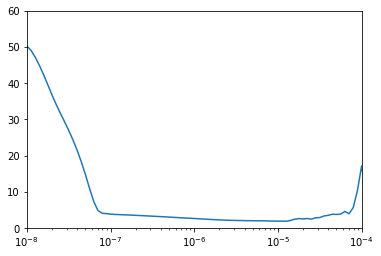

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

**Comentarios adicionales sobre el uso de las funciones callback y, en particular, el LearningRateScheduler**

Comenzamos presentando las funciones callback, la cuales son funciones que se ejecutan durante el entrenamiento y que nos pueden servir para monitorizar ciertos aspectos de dicho entrenamiento.

Entendemos que el objetivo del LearningRateScheduler es la de ir modificando el Learning Rate y ver cómo afecta al aprendizaje de la NN.

El motivo por el que se busca estabilidad y se realizan comparaciones locales, centrándose en los valores vecinos, es por que dicha modificación se va realizando según se entrena la red (más en concreto en el epoch 1 se tiene un lr = 1e-8 y en el epoch 100 lr = 1e-4), por lo que es de esperar que el loss en el epoch 1 sea superior al loss en el epoch 100 en el que la NN ya está entrenada.

El interés y valor de esta prueba, como decíamos, radica en la comparación con los valores cercanos, buscando momentos de estabilidad (siempre teniendo en cuenta que la tendencia del loss será la de ir descreciendo debido a las mejoras inherentes que produce el paso de las epcochs en el entrenamiento).

Habiendo establecido este contexto, se puede concluir que el un valor correcto del lr podría ser 1e-5, y que si se sigue aumentando dicho lr, el loss aumenta, posiblemente porque la NN empieza a "dar saltos" entorno a las soluciones óptimas y el entrenamiento deja de ser efectivo.

Se vuelve a inicializar la sesión de entrenamiento y la variable train_set:

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)

**Ejercicio 6 (0.5 puntos)**: Para crear el nuevo modelo, reutiliza la red neuronal diseñada en el ejercicio 5, pero esta vez utilizando 60 filtros en la capa de convolución.

In [ ]:
## tu código para la red neuronal del ejercicio 6 aquí

tf.keras.backend.clear_session()

model = Sequential()
model.add(Conv1D(60, 5, input_shape=(None,1), strides =1, padding = 'causal', activation='relu')) # aumentamos el número de filtros convolucionales hasta 60
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(64, return_sequences=True))
model.add(Dense(30, activation='relu'))
model.add(Dense(10, activation = 'relu'))
model.add(Dense(1))
model.add(tf.keras.layers.Lambda(lambda x: x * 400))


**Ejercicio 7 (0.5 puntos)**: Se debe volver a compilar la red neuronal de manera análoga a la del ejercicio 5, pero esta vez utilizar un learning rate obtenido de la función callback.

In [ ]:
## tu código para compilar la red neuronal para el ejercicio 7 aquí

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9) # utilizamos ya el lr deducido gracias a la función callback, i.e. 1e-5

model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer,metrics=['mae'])

In [ ]:
history = model.fit(train_set,epochs=150)

Epoch 1/150
25/25 [==============================] - 4s 13ms/step - loss: 10.5953 - mae: 11.0882
Epoch 2/150
25/25 [==============================] - 0s 14ms/step - loss: 3.3121 - mae: 3.7836
Epoch 3/150
25/25 [==============================] - 0s 14ms/step - loss: 2.0117 - mae: 2.4675
Epoch 4/150
25/25 [==============================] - 0s 14ms/step - loss: 1.8765 - mae: 2.3288
Epoch 5/150
25/25 [==============================] - 0s 14ms/step - loss: 1.8225 - mae: 2.2738
Epoch 6/150
25/25 [==============================] - 0s 14ms/step - loss: 1.7814 - mae: 2.2319
Epoch 7/150
25/25 [==============================] - 0s 14ms/step - loss: 1.7614 - mae: 2.2113
Epoch 8/150
25/25 [==============================] - 0s 13ms/step - loss: 1.7416 - mae: 2.1908
Epoch 9/150
25/25 [==============================] - 0s 13ms/step - loss: 1.7415 - mae: 2.1901
Epoch 10/150
25/25 [==============================] - 0s 14ms/step - loss: 1.7103 - mae: 2.1582
Epoch 11/150
25/25 [===========================

# 7. Predicción de los siguientes valores de la serie temporal

Para concluir la actividad, se usa el método model_forecast que se ha diseñado utilizando el método de la ventana temporal para hacer el nuevo metodo rnn_forecast con el cual se calcularán los nuevos valores de la serie temporal. Posteriormente, se pinta una gráfica para ver esos resultados y comprobar de forma visual que son correctos. Además, se dan los resultados de esas predicciones en forma númerica, de esta forma, este modelo diseñado en esta actividad podría ser el input de un nuevo algoritmo si fuera necesario.

In [ ]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

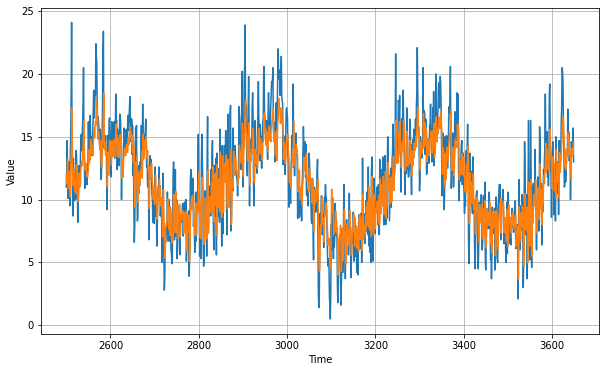

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

1.8275388

In [ ]:
print(rnn_forecast)

[11.870073 11.263563 12.266113 ... 13.510111 13.546162 14.574684]


# 8. Mostrar gráficamente los resultados.

Una vez obtenido el resultado de la actividad, se procede a revisr de forma gráfica el training y validation loss a lo largo de los epochs en este nuevo entrenamiento con el learning rate optimizado.

In [ ]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Recuperar una lista de resultados de la lista de datos de entrenamiento y pruebas para cada epoch de entrenamiento
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

A continuación se realiza el plot de la pérdida frente a los epochs

<Figure size 432x288 with 0 Axes>

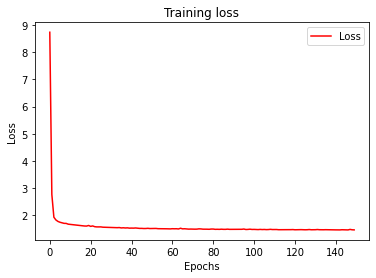

<Figure size 432x288 with 0 Axes>

In [ ]:
#------------------------------------------------
# Pérdida de entrenamiento y validación por epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

**Ejercicio 8 (0.5 punto)**: Utilizando las 2 nuevas variables zoomed_loss y zoomed_epochs y con base en el código anterior, hacer el plot del loss frente a los epochs entre los epoch 20 y 150 para ver como va oscilando y no es un proceso lineal como podria parecer según el anterior plot.

<Figure size 432x288 with 0 Axes>

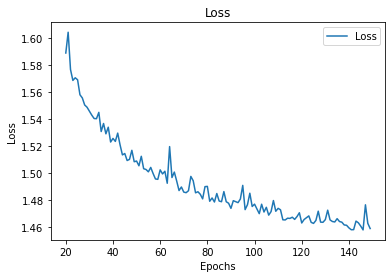

<Figure size 432x288 with 0 Axes>

In [ ]:
#------------------------------------------------
# Pérdida de entrenamiento y validación por epoch con zoom
#------------------------------------------------
zoomed_loss = loss[20:]
zoomed_epochs = epochs[20:]
#
## tu código para el plot con zoom del ejercicio 8 aquí

plt.plot(zoomed_epochs, zoomed_loss)
plt.title('Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

Como se puede apreciar en la gráfica con zoom, la función de pérdida no es un proceso lineal, si no que va oscilando en cada época. Esto es completamente razonable debido a que, a lo largo del entrenamiento, el modelo se encuentra en un proceso de aprendizaje. A pesar de las oscilaciones, se puede apreciar que, en general, la pérdida va disminuyendo según se van ejecutando las épocas.